# Transfer Learning with TensorFlow Part 2: Fine-tuning

In the previous notebook, we coverd transfer learning feature extraction, now it's time to learn about a new kind of tranfer learning: fine-tuning.

In [ ]:
# Check if we're using a GPU
!nvidia-smi

## Creating helper functions
In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere).

we've done this for some of the function we've used previosly here:
https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [2]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir 

**Note:** If you're running this notebook in Google Colab, when it times out Colab will delete `helper_functions.py`, so you'll have to redownload it if you want acces to your helper functions.

## Let's get some data


This time we're going to see how we can use the pretrained model within `tf.keras.applications` and apply them to our own problem(recognizing images of food).

link:https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [ ]:
# Get 10% of training data of 10 classes of Food101:

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
    
unzip_data("10_food_classes_10_percent.zip")

In [3]:
# Check out how many images and subdirectories are in our dataset

walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 2 directories and 0 images in '10_food_classes_10_percent\10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 

In [11]:
# Create training and test directory paths
train_dir ="10_food_classes_10_percent/10_food_classes_10_percent/train/"
test_dir ="10_food_classes_10_percent/10_food_classes_10_percent/test/"

In [12]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
# ahora utilizaremos otra forma mas rapida
train_data_10_percent= tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical",
                                                                           batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [13]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [14]:
# Check out the class names of our dataset

train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [15]:
# See an example of a batch of data

# "take" es un metodo que me desenvuelve un lote(bach)
# los lotes se componen de 32 imagenes, 
for images, labels in train_data_10_percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[254.5153    253.7449    249.7449   ]
   [254.35715   253.71428   249.71428  ]
   [254.78572   255.        250.78572  ]
   ...
   [254.        255.        250.       ]
   [254.        255.        250.       ]
   [254.        255.        250.       ]]

  [[255.        254.02551   250.02551  ]
   [254.85715   253.85715   249.85715  ]
   [254.05612   253.4847    249.2704   ]
   ...
   [254.        255.        250.       ]
   [254.        255.        250.       ]
   [254.        255.        250.       ]]

  [[242.58673   241.58673   237.58673  ]
   [253.25511   252.25511   248.25511  ]
   [253.59694   252.97958   248.81122  ]
   ...
   [254.        255.        250.       ]
   [254.        255.        250.       ]
   [254.        255.        250.       ]]

  ...

  [[221.35202   182.35202   229.35202  ]
   [214.15816   175.15816   220.18877  ]
   [212.13785   170.70927   214.495    ]
   ...
   [176.74965   147.10686   195.32112  ]
   [179.88745   150.24466   198.45892  ]
   [1

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models. -https://www.tensorflow.org/guide/keras/functional?hl=es-419

In [18]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trainet patterns aren't updated during training)

base_model.trainable = False


# 3. Create inputs into our model

inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer" )

# 4. If using a model like ResNet50V2 you will needto normalize imputs(you don't have to for efficientNet(porque efficiente net rescala automatico, cuando usamos .keras.aplications))

#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model

x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model ( aggregate all the most important information, reduce number of computation)

x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model

model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile for the model

model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len(test_data)),
                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name="10_percent_feature_extration")])

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extration/20210515-083540
Epoch 1/5
24/24 [==============================] - 96s 4s/step - loss: 2.0426 - accuracy: 0.3174 - val_loss: 1.3181 - val_accuracy: 0.7138
Epoch 2/5
24/24 [==============================] - 77s 3s/step - loss: 1.1732 - accuracy: 0.7308 - val_loss: 0.9523 - val_accuracy: 0.7451
Epoch 3/5
24/24 [==============================] - 76s 3s/step - loss: 0.8292 - accuracy: 0.8123 - val_loss: 0.7831 - val_accuracy: 0.7895
Epoch 4/5
24/24 [==============================] - 77s 3s/step - loss: 0.6958 - accuracy: 0.8558 - val_loss: 0.7085 - val_accuracy: 0.8043
Epoch 5/5
24/24 [==============================] - 76s 3s/step - loss: 0.5741 - accuracy: 0.8729 - val_loss: 0.6683 - val_accuracy: 0.8059


In [19]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 157s 2s/step - loss: 0.6031 - accuracy: 0.8364


[0.6031010746955872, 0.8363999724388123]

In [20]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_3
1 rescaling_2
2 normalization_2
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_d

In [21]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, None, None, 3 7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization_2[0][0]            
_____________________________________________________________________________________

In [22]:
# How about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


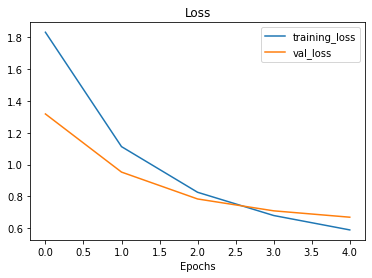

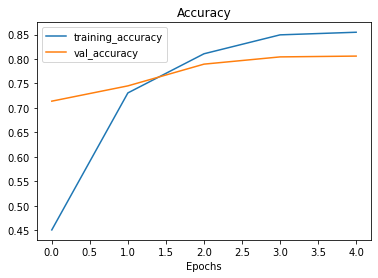

In [23]:
#Check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from trained model

Let's demonstrate the global average Pooling 2D layer....

We have a tensor after our model goes through `base_model` of shape(None,7, 7, 1280)
But then when it passes through GlobalAveragePooling2D, it turns into(None, 1280)


Let's use a similar shaped tensor of (1, 4, 4, 3)  and then pass it to GlobalAveragePooling2D.

**basicamente transformaros un tensor de 4 dimensiones en uno de 2**


In [30]:
# Define the input shape

input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer

global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)

print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# global_average lo condensa todo en un tensor que se " come" o elimina las dimensiones intermedias, dejando solo un tensor de dimesiones iguales al inicio y al final
#(creo que lo hace asi por cada columna(eje mas externo))

# condensa todo en un vector mas peque;o pero que retiene la informacion 

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor:{global_average_pooled_tensor.shape}")

random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840445 -0.28855976]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor:(1, 3)


In [31]:
# Let's replicate the GlobalAveragePool2D layer
# forma de sacar el promedio por colunmas del tensor de 4 dimensiones
# debemos especificar los ejes internos
# con esto sacamos el vector de caracteristicas
# esto es una representacion de lo que el model ha aprendido
# luego entranamos la output layer con el resultado de esto
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

**Practice:** Try to do the same with the above two cells but this time use `GlobalMaxPool2D` and see what happens.

**Note:** One of the reasons feature extraction transfer learning is named how it is because what often happens is pretrained model ouputs a **feature vector**(a long tensor of numbers which represent the learned respresentation of the model on a particular sample, this is the ouput of the `tf.keras.layers.GlobalAveragePooling2D()` layer which can then be uset to extract patterns out of for own specific problem.

### Running a series of transfer learning experiments

We've seen the incresible result transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data .... how about we set up a bunch of experiment to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation

2. `model_2`- use feature extraction transfer learning with 10% of the training with data augmentation

3. `model_3`- use fine-tuning transfer learning on 10% of the training data with data augmentation

4. `model_4` - use fine-tuning transfer learning on 100 % of the training data with data augmentation

>**Note:** Throughout all experiments the same test dataset will be used to evaluate our model .. this ensures consistency across evaluation metrics.

### Getting and preprocessing data for model_1

In [33]:
# Download and unzipdata  - preprocessed from Food101
unzip_data("10_food_classes_1_percent.zip")

In [34]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"


test_dir = "10_food_classes_1_percent/test/"

In [35]:
# How many images are we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent\test'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\sushi'

In [37]:
# Setup data loaders
IMG_SIZE = (224, 224)

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=32)# default = 32

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model
#print(tf.__version__)

To add augmentation right into our models, we can use the layers inside:
* `tf.keras.layers.experimental.preprocessing()`

We can see the benefits of doing this within the TensorFlow data augmentation documentation : 
https://www.tensorflow.org/tutorials/images/data_augmentation


Off the top our of heads, after reading the  docs, the benefits of using data augmentation inside the model are:

* Preprocessing of images(augmenting them) happens on the GPU (much faster) rather thn the CPU.

* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.



In [39]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotation, zooms, etc

data_augmentation = keras.Sequential([
    
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
#     preprocessing.Rescaling(1./255) # Keep for models like ResNet50V2 but EfficientNet's having reescaling builtin
    
], name="data_augmentation")

### Visualize our data augmentation layer(and see what happens to our data)

(-0.5, 582.5, 510.5, -0.5)

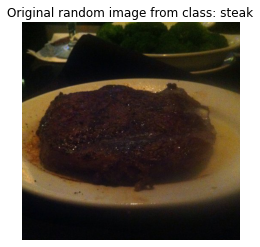

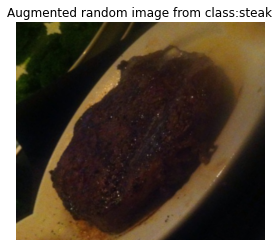

In [59]:
# View a random image and compare it to ist augmented version
import matplotlib.pyplot as plt

import matplotlib.image as mpimg

import os 

import random

target_class = random.choice(train_data_1_percent.class_names)

target_dir = "10_food_classes_1_percent/train/" + target_class

random_image = random.choice(os.listdir(target_dir))

random_image_path = target_dir + "/" + random_image

# Read and plot in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

# Now let's plot our augmented random image

# para aumentar a;adimos una dimension, porque es lo que espera mi objeto data_augmentation
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))

# creamos una nueva figura
plt.figure()
# para poder dibujar luego de haber sido augmented le quitamos las dimensiones extras
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class:{target_class}")
plt.axis(False)
#print(augmented_img)




In [41]:
train_data_1_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

# Model 1: Feature extraction transfer learning on  1% of the data with data agumentation

In [62]:
# Setup input shape and base model, freezing the base model layers

input_shape =(224, 224, 3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)


base_model.trainable = False

# Create input layer

inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer

x = data_augmentation(inputs)


# Give base_model the inputs(after augmentation) and don't train it

# cuando queremos pasar la fase anterior a un modelo completo, lo pasamos entre parentesis
x = base_model(x, training=False)

# Pool output features of the base model

# como esto es solo una capa la ponemos de esta forma
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output

outputs = layers.Dense(10, activation="softmax", name="output_layer" )(x)


# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# compile the model

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model

history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 *  len(test_data)),
                                # Track model trainig logs
                                # le paso donde quiero guardarlo y como llamare al experimento
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name = "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20210515-160026
Epoch 1/5
3/3 [==============================] - 50s 21s/step - loss: 2.3655 - accuracy: 0.0930 - val_loss: 2.2081 - val_accuracy: 0.1891
Epoch 2/5
3/3 [==============================] - 38s 18s/step - loss: 2.1143 - accuracy: 0.2497 - val_loss: 2.0922 - val_accuracy: 0.2911
Epoch 3/5
3/3 [==============================] - 39s 18s/step - loss: 1.9780 - accuracy: 0.3843 - val_loss: 1.9662 - val_accuracy: 0.3799
Epoch 4/5
3/3 [==============================] - 38s 18s/step - loss: 1.8446 - accuracy: 0.4655 - val_loss: 1.8798 - val_accuracy: 0.4309
Epoch 5/5
3/3 [==============================] - 41s 19s/step - loss: 1.6766 - accuracy: 0.5994 - val_loss: 1.7915 - val_accuracy: 0.4655


In [61]:
IMG_SIZE +(3,)

(224, 224)

In [63]:
# Check out a model summary

model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [64]:
# Evaluate on the full test dataset

results_1_percent_data_aug =  model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 140s 2s/step - loss: 1.8217 - accuracy: 0.4496


[1.8217369318008423, 0.4496000111103058]

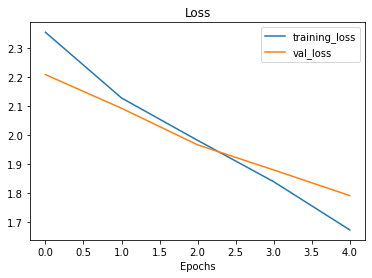

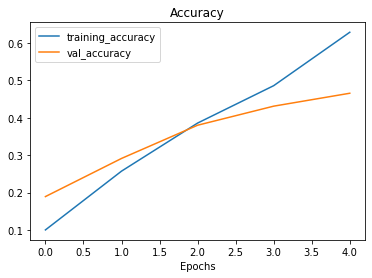

In [65]:
# how do the model go with 1 % of  the and data augmentation loss curves look?
plot_loss_curves(history_1_percent)

## Model 2: Feature extraction transfer learning model with 10% of data and data augmentation

In [66]:
# get 10 % of data...(uncomment if you don't have it)

# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# unzip_data(10_food_classes_10_percent)

train_dir_10_percent = "10_food_classes_10_percent/10_food_classes_10_percent/train/"

test_dir_10_percent = "10_food_classes_10_percent/10_food_classes_10_percent/test/"



In [67]:
# Set data inputs
import tensorflow as tf

IMG_SIZE = (224, 224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size =IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [68]:
# how many images are in our directories?

walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 2 directories and 0 images in '10_food_classes_10_percent\10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 

In [69]:
data_augmentation.summary()

Model: "data_augmentation"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, None, None, 3)     0         
_________________________________________________________________
random_rotation (RandomRotat (None, None, None, 3)     0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, None, None, 3)     0         
_________________________________________________________________
random_height (RandomHeight) (None, None, None, 3)     0         
_________________________________________________________________
random_width (RandomWidth)   (None, None, None, 3)     0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [72]:
# Create model 2 with data augmentacion built in

from tensorflow.keras import layers

from tensorflow.keras.layers.experimental import preprocessing

from tensorflow.keras.models import Sequential


# Build data augmentation layer

data_augmentation= Sequential([
    
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    
    # preprocessing.Rescaling(1./255) # if you're using a model such as ResNet50V2, you'll need to rescale your data, efficienet has rescaling built-in
    
    
    
], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model(also called the backbone)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False


# Create the inputs and outputs ( including the layers in between)

inputs = layers.Input(shape=input_shape, name="input_layer")

x = data_augmentation(inputs) # augment our training images (augmentation doesn't occu on test data)

x = base_model(x, training=False) #  oass augmented images to base model but keep it in inference mode. this also insures batchnorm layers don't get updated https://keras.io/guides/transfer_learning/#build-a-model

x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)

outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

model_2 = tf.keras.Model(inputs, outputs)


# Compile

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [71]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_3 (Rescaling)         (None, None, None, 3 0           input_4[0][0]                    
__________________________________________________________________________________________________
normalization_3 (Normalization) (None, None, None, 3 7           rescaling_3[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization_3[0][0]            
_____________________________________________________________________________________

block3a_se_squeeze (GlobalAvera (None, 144)          0           block3a_activation[0][0]         
__________________________________________________________________________________________________
block3a_se_reshape (Reshape)    (None, 1, 1, 144)    0           block3a_se_squeeze[0][0]         
__________________________________________________________________________________________________
block3a_se_reduce (Conv2D)      (None, 1, 1, 6)      870         block3a_se_reshape[0][0]         
__________________________________________________________________________________________________
block3a_se_expand (Conv2D)      (None, 1, 1, 144)    1008        block3a_se_reduce[0][0]          
__________________________________________________________________________________________________
block3a_se_excite (Multiply)    (None, None, None, 1 0           block3a_activation[0][0]         
                                                                 block3a_se_expand[0][0]          
__________

block4b_bn (BatchNormalization) (None, None, None, 4 1920        block4b_dwconv[0][0]             
__________________________________________________________________________________________________
block4b_activation (Activation) (None, None, None, 4 0           block4b_bn[0][0]                 
__________________________________________________________________________________________________
block4b_se_squeeze (GlobalAvera (None, 480)          0           block4b_activation[0][0]         
__________________________________________________________________________________________________
block4b_se_reshape (Reshape)    (None, 1, 1, 480)    0           block4b_se_squeeze[0][0]         
__________________________________________________________________________________________________
block4b_se_reduce (Conv2D)      (None, 1, 1, 20)     9620        block4b_se_reshape[0][0]         
__________________________________________________________________________________________________
block4b_se

block6b_drop (Dropout)          (None, None, None, 1 0           block6b_project_bn[0][0]         
__________________________________________________________________________________________________
block6b_add (Add)               (None, None, None, 1 0           block6b_drop[0][0]               
                                                                 block6a_project_bn[0][0]         
__________________________________________________________________________________________________
block6c_expand_conv (Conv2D)    (None, None, None, 1 221184      block6b_add[0][0]                
__________________________________________________________________________________________________
block6c_expand_bn (BatchNormali (None, None, None, 1 4608        block6c_expand_conv[0][0]        
__________________________________________________________________________________________________
block6c_expand_activation (Acti (None, None, None, 1 0           block6c_expand_bn[0][0]          
__________

In [73]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_2D (G (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [74]:
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


### Creating a ModelCheckpoint callback

The ModelCheckpoint callback intermediately saves our model ( the full model or just the weights) during training.  This is usefull so we can come and start where we left off.

In [76]:
# Set checkpoint path
checkpoint_path ="ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",# save every epoch
                                                         verbose=1 )

### Fit model 2 passing in the ModelCheckpoint  callbacks

In [80]:
# Fit the model saving checkpoint every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                              epochs=initial_epochs,
                              validation_data=test_data,
                              validation_steps=int(0.25 * len(test_data)),
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                     experiment_name ="10_percent_data_aug"),
                                         checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20210515-203509
Epoch 1/5
24/24 [==============================] - 99s 4s/step - loss: 2.1601 - accuracy: 0.2319 - val_loss: 1.5386 - val_accuracy: 0.5987

Epoch 00001: saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 81s 3s/step - loss: 1.4484 - accuracy: 0.6177 - val_loss: 1.0834 - val_accuracy: 0.7467

Epoch 00002: saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 78s 3s/step - loss: 1.1185 - accuracy: 0.7119 - val_loss: 0.9074 - val_accuracy: 0.7812

Epoch 00003: saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 90s 4s/step - loss: 0.9257 - accuracy: 0.7717 - val_loss: 0.7758 - val_accuracy: 0.7845

Epoch 00004: saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
Epoch 5/5
24/24 [====

In [81]:
# What were model_0 result?
model_0.evaluate(test_data)

79/79 [==============================] - 147s 2s/step - loss: 0.6031 - accuracy: 0.8364


[0.6031009554862976, 0.8363999724388123]

In [85]:
results_10_percent_data_aug =model_2.evaluate(test_data)



79/79 [==============================] - 147s 2s/step - loss: 0.7161 - accuracy: 0.8080


NameError: name 'result_10_percent_data_aug' is not defined

In [87]:
results_10_percent_data_aug

[0.7160730957984924, 0.8080000281333923]

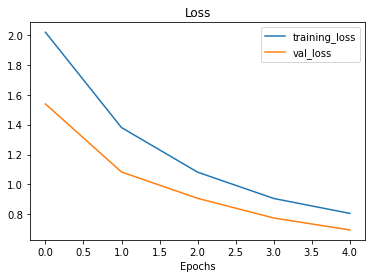

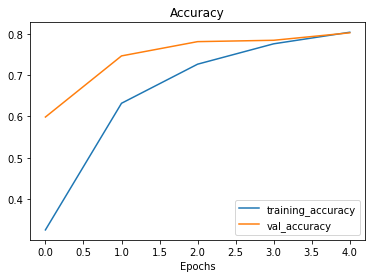

In [88]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights
con los checkpoint puedo regresar a un punto anterior
Loading in checkpointed weights return a model to a specific checkpoint

In [89]:
checkpoint_path

'ten_percent_model_checkpoints_weights/checkpoint.ckpt'

In [90]:
# Load in saved model weights and evaluate model

model_2.load_weights(checkpoint_path)



In [94]:
# Evaluate model_2 with loaded weight
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 146s 2s/step - loss: 0.7161 - accuracy: 0.8080


In [97]:
# If the results from our previously evaluated model_2 match the loaded weights, everythings has worked
results_10_percent_data_aug == loaded_weights_model_results

True

In [98]:
# check to see if loaded model results are very close to our previos non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug),np.array(loaded_weights_model_results) )

array([ True,  True])

In [101]:
# Check the difference between the two results

print(np.array(results_10_percent_data_aug)- np.array(loaded_weights_model_results))

[0. 0.]


## Model 3: Fine-tunning an existing model on 10% of the data

> **Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

In [102]:
# Layers in loaded model

model_2.layers

In [103]:
# Are these layers trainable?

for layer in model_2.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000002251065CE80> True
<tensorflow.python.keras.engine.sequential.Sequential object at 0x000002251065CD30> True
<tensorflow.python.keras.engine.functional.Functional object at 0x0000022512E12A20> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x00000225121A39E8> True
<tensorflow.python.keras.layers.core.Dense object at 0x000002251D961C88> True


In [104]:
# What layers are in our base_model(EfficientNetB0) and are they trainable? 
for  i, layer  in  enumerate(model_2.layers[2].layers):
    print( i, layer.name, layer.trainable)

0 input_5 False
1 rescaling_4 False
2 normalization_4 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [105]:
# How many trainable variables are in our base model ?
print(len(model_2.layers[2].trainable_variables))

0


In [108]:
# To begin fine-tuning, let'start by setting the last 10 layers of our  base_model.trainable = True

base_model.trainable =  True

# Freeze all layers except for the last 10

# estamos excluyendo las ultimas 10
# esto se lee "todas hasta las ultimas 10"
for layer in base_model.layers[:-10]:
    layer.trainable = False
    
# Recompile (we have to recompile our model every time we make a change)

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001), # when fine-tuning you typically want to lowe the learning rate by 10x
                metrics=["accuracy"])

> **Note:** When using fine-tuning it's best practice to lower your learning rate by some amount.(queremos que no varie demasiado). How much? This is a hyperparameter you can tune. But a good rule of thumb is at least 10x( though different sources will claim other values). A good resource for information on this is the ULMfiT paper: https://arxiv.org/abs/1801.06146

In [109]:
# Check which layer are tunable(trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_5 False
1 rescaling_4 False
2 normalization_4 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [107]:
for layer in base_model.layers[:-10]:
    layer.trainable = False
    print(layer.name)

input_5
rescaling_4
normalization_4
stem_conv_pad
stem_conv
stem_bn
stem_activation
block1a_dwconv
block1a_bn
block1a_activation
block1a_se_squeeze
block1a_se_reshape
block1a_se_reduce
block1a_se_expand
block1a_se_excite
block1a_project_conv
block1a_project_bn
block2a_expand_conv
block2a_expand_bn
block2a_expand_activation
block2a_dwconv_pad
block2a_dwconv
block2a_bn
block2a_activation
block2a_se_squeeze
block2a_se_reshape
block2a_se_reduce
block2a_se_expand
block2a_se_excite
block2a_project_conv
block2a_project_bn
block2b_expand_conv
block2b_expand_bn
block2b_expand_activation
block2b_dwconv
block2b_bn
block2b_activation
block2b_se_squeeze
block2b_se_reshape
block2b_se_reduce
block2b_se_expand
block2b_se_excite
block2b_project_conv
block2b_project_bn
block2b_drop
block2b_add
block3a_expand_conv
block3a_expand_bn
block3a_expand_activation
block3a_dwconv_pad
block3a_dwconv
block3a_bn
block3a_activation
block3a_se_squeeze
block3a_se_reshape
block3a_se_reduce
block3a_se_expand
block3a_se_

In [110]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables are there?

print(len(model_2.trainable_variables))

12


In [113]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)

history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                              epochs=fine_tune_epochs,
                                              validation_data= test_data,
                                              validation_steps=int(0.25 * len(test_data)),
                                              initial_epoch=history_10_percent_data_aug.epoch[-1], # start training from previous last epoch
                                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                     experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20210516-041957
Epoch 5/10
24/24 [==============================] - 107s 4s/step - loss: 0.6745 - accuracy: 0.8158 - val_loss: 0.5775 - val_accuracy: 0.8191
Epoch 6/10
24/24 [==============================] - 82s 3s/step - loss: 0.5541 - accuracy: 0.8292 - val_loss: 0.5878 - val_accuracy: 0.8109
Epoch 7/10
24/24 [==============================] - 77s 3s/step - loss: 0.5351 - accuracy: 0.8250 - val_loss: 0.5402 - val_accuracy: 0.8125
Epoch 8/10
24/24 [==============================] - 83s 4s/step - loss: 0.4495 - accuracy: 0.8523 - val_loss: 0.5676 - val_accuracy: 0.8207
Epoch 9/10
24/24 [==============================] - 79s 3s/step - loss: 0.4028 - accuracy: 0.8757 - val_loss: 0.5025 - val_accuracy: 0.8289
Epoch 10/10
24/24 [==============================] - 83s 3s/step - loss: 0.3770 - accuracy: 0.8826 - val_loss: 0.5241 - val_accuracy: 0.8207


In [114]:
# Evaluate the fine_tuned model (model_3 which is actually model_2 fine-tuned for another 5 epochs)

results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 146s 2s/step - loss: 0.5122 - accuracy: 0.8284


In [115]:
results_10_percent_data_aug

[0.7160730957984924, 0.8080000281333923]

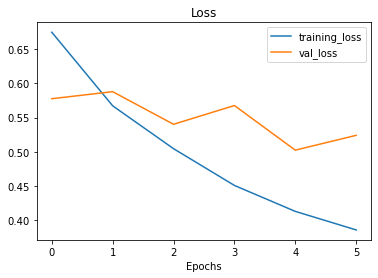

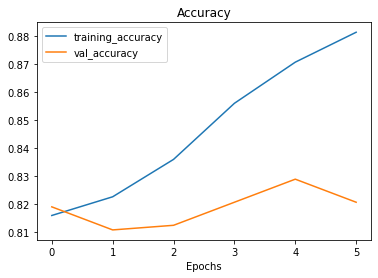

In [116]:
# Check out the loss curves of our fine_tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compare one series of running `fit `with another( e.g before and after fine-tuning)

In [125]:
# Let's create a function to compare training histories

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compare two TensorFlow history objects.
    
    """
    
    # Get original history measurements
    
    acc = original_history.history["accuracy"]
    
    loss = original_history.history["loss"]
    
    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]
    
    
    # Combine original history with new_history metrics
    
    total_acc = acc + new_history.history["accuracy"]
    
    total_loss = loss + new_history.history["loss"]
    
    
    total_val_acc = val_acc + new_history.history["val_accuracy"]
    
    total_val_loss = val_loss + new_history.history["val_loss"]
    
    
    # Make plots for accuracy
    plt.figure(figsize=(8, 8))
    
    plt.subplot(2, 1, 1)
    
    plt.plot(total_acc, label ="Training Accuracy")
    
    plt.plot(total_val_acc, label ="Val Accuracy")
    
    # puedo crear una lineal vertical, dibujando un punto consigo mismo
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Star fine Tunning")
    
    plt.legend(loc="lower right")
    
    plt.title("training and validation Accuracy")
    
    # Make plot for loss
    plt.figure(figsize=(8, 8))
    
    # el elemento 2
    plt.subplot(2, 1, 2)
    
    plt.plot(total_loss, label ="Training loss")
    
    plt.plot(total_val_loss, label ="Val loss")
    
    # puedo crear una lineal vertical, dibujando un punto consigo mismo
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Star fine Tunning")
    
    plt.legend(loc="upper right")
    
    plt.title("training and validation loss")
    

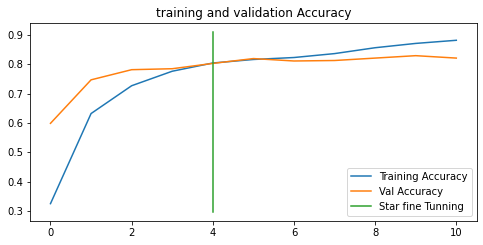

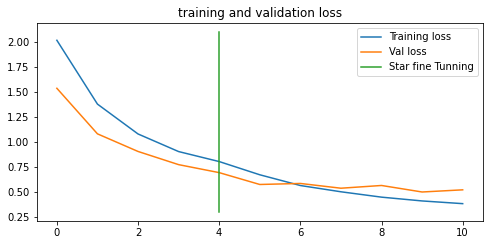

In [126]:
compare_historys(history_10_percent_data_aug,
                 history_fine_10_percent_data_aug,
                 initial_epochs=5)

## Model 4: Fine-tunning and existing model on all of the data

In [ ]:
# Download and unzip 10 classes of Food101 data with all images

In [127]:
# Setup training and test dir
train_dir_all_data = "10_food_classes_all_data/train/"

test_dir = "10_food_classes_all_data/test/"

In [128]:
# How many images are we working with now?

walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data\test'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\steak'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\sushi'.
There are 

In [129]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode ="categorical",
                                                                                 image_size=IMG_SIZE)


test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for previous experiments (all experiment have used the same test dataset).

Let's verify thiss..

In [130]:
# Evaluate model 2 (this is the fine-tuned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 148s 2s/step - loss: 0.5122 - accuracy: 0.8284


[0.5121514201164246, 0.8284000158309937]

In [131]:
results_fine_tune_10_percent

[0.5121513605117798, 0.8284000158309937]

To train a fine_tunning model (model_4) we need to revert model_2 to its feature extraction weights.

In [132]:
# Load weights from checkpoint, that way we can fine-tune from 
#the same stage the 10 percent data model was fine-tuned from 

model_2.load_weights(checkpoint_path)

In [133]:
# Let's evaluate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 145s 2s/step - loss: 0.7161 - accuracy: 0.8080


[0.7160732746124268, 0.8080000281333923]

In [134]:
# Check to see if our model_2 has been reverted back to feature extraction result
results_10_percent_data_aug



[0.7160730957984924, 0.8080000281333923]

Alright, the previous steps might seem quite confusing but all we've done is:
    
   1. Trained a feacture extraction transfer learning model for 5 epochs on 10% of the data with data augmentation(model_2) and we saved the model's weights using `ModelCheckpoint` callback.
   2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen(model_3).
    
   3. Saved the results and training logs each time.
    
   4. Reloaded the model from step 1 to do the same steps as step 2 except this time we're going to use all of the data(model_4)
   

In [136]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [138]:
# Let's drill into our base_model(efficientnetb0) and see what layers are trainable

for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_5 False
1 rescaling_4 False
2 normalization_4 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [139]:
# Compile

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics=["accuracy"])

In [143]:
# Continue to train and fine-tune the model to our data (100% of  training data )

fine_tune_epochs = initial_epochs + 5 

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                  experiment_name="full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20210516-075445
Epoch 5/10
235/235 [==============================] - 532s 2s/step - loss: 0.8256 - accuracy: 0.7402 - val_loss: 0.4164 - val_accuracy: 0.8536
Epoch 6/10
235/235 [==============================] - 506s 2s/step - loss: 0.6388 - accuracy: 0.7959 - val_loss: 0.3736 - val_accuracy: 0.8734
Epoch 7/10
235/235 [==============================] - 502s 2s/step - loss: 0.5620 - accuracy: 0.8211 - val_loss: 0.3089 - val_accuracy: 0.8964
Epoch 8/10
235/235 [==============================] - 510s 2s/step - loss: 0.5176 - accuracy: 0.8319 - val_loss: 0.3663 - val_accuracy: 0.8865
Epoch 9/10
235/235 [==============================] - 509s 2s/step - loss: 0.4796 - accuracy: 0.8454 - val_loss: 0.2940 - val_accuracy: 0.9079
Epoch 10/10
235/235 [==============================] - 494s 2s/step - loss: 0.4498 - accuracy: 0.8542 - val_loss: 0.3256 - val_accuracy: 0.9013


In [144]:
# Let's evaluate on all of the test data
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data 

79/79 [==============================] - 152s 2s/step - loss: 0.3455 - accuracy: 0.8892


[0.3455103635787964, 0.88919997215271]

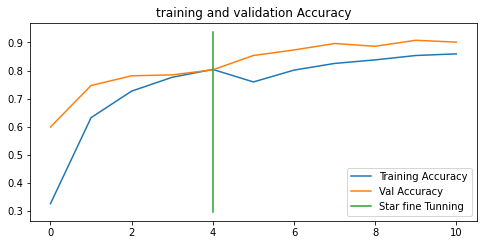

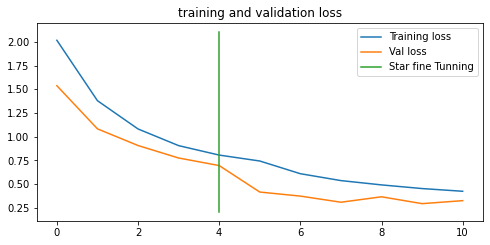

In [147]:
 # how did fine-tuning go with more data?
compare_historys(original_history=history_10_percent_data_aug,
                new_history=history_fine_10_classes_full,
                initial_epochs=5) 


In [148]:
%load_ext tensorboard

## Viewing our experiment data on TensorBoard


> **Note:** Anything you upload to TensorBoard.dev is going to be public. So ig you have private data , do not upload

In [153]:
# View tensorboard logs of transfer learning modelling (should 4 model

# Upload Tensorboar 

%tensorboard --logdir ./transfer_learning

Reusing TensorBoard on port 6006 (pid 14912), started 0:02:09 ago. (Use '!kill 14912' to kill it.)

In [152]:
%tensorboard

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2021-05-16 14:31:30.998075: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-05-16 14:31:30.998231: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Error: A logdir or db must be specified. For example `tensorboard --logdir mylogdir` or `tensorboard --db sqlite:~/.tensorboard.db`. Run `tensorboard --helpfull` for details and examples.

In [154]:
# View all of your uploaded Tensorboard experiment
!tensorboard dev list

^C


In [ ]:
# # To delete an experiment
#  ! tensorboard dev delete --- experiment_id codigodad